# **Detecting and Classifying Brain tumors Using Deep Learning**

Guichard Manigat

Richard Will

Ackley Will, PhD

CPTR 475 001 Top: Computer Vision

December 9, 2024

*Kaggle Dataset: https://www.kaggle.com/datasets/sartajbhuvaji/brain-tumor-classification-mri*

## **Problem Description**
Brain tumors are complex and difficult to detect. Manual analysis of MRI is error prone and time-consuming, especially in regions with low access to skilled professionals. This project aims to create an automated system using Deep Learning, specifically Convolutional Neural Networks (CNN), to detect and classify brain tumors. By analyzing MRI images, we can make faster and more reliable decisions.

## **Importing Libraries**

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import OneHotEncoder

import seaborn as sns

2025-03-05 11:12:40.374000: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-05 11:12:40.387026: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-05 11:12:40.391173: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-05 11:12:40.401165: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
import keras

from keras import models, regularizers
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.callbacks import EarlyStopping
import visualkeras # For visualising layers

In [3]:
testing_path = os.path.join(os.getcwd(), 'brain-tumor-classification-mri', 'Testing')
training_path = os.path.join(os.getcwd(), 'brain-tumor-classification-mri', 'Training')

## **Data Preperation**


In [4]:
EPOCHS = 50
IMG_HEIGHT, IMG_WIDTH = 128, 128

In [5]:
# Function to load images and labels
def load_images_from_directory(directory, show_img = False):
    images = []
    labels = []
    idx = 1
    for sub_dir in os.listdir(directory):
        sub_dir_path = os.path.join(directory, sub_dir)
        for filename in os.listdir(sub_dir_path):
            img_path = os.path.join(sub_dir_path, filename)
            img = cv2.resize(cv2.imread(img_path, cv2.IMREAD_GRAYSCALE), (IMG_HEIGHT, IMG_WIDTH))
            images.append(img)
            labels.append(sub_dir)
        if show_img:
            plt.subplot(1, 4, idx)
            plt.axis('off')
            plt.title(sub_dir)
            plt.imshow(img, cmap="gray")
        idx += 1
    return images, labels

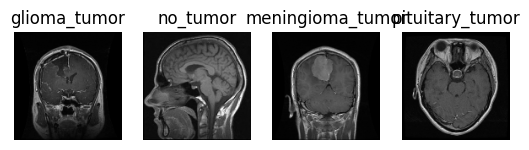

In [6]:
training_images, training_labels = load_images_from_directory(training_path, show_img=True)
testing_images, testing_labels = load_images_from_directory(testing_path, show_img=False)

original_images = training_images + testing_images
labels = training_labels + testing_labels

In [7]:
print(f"Number of labels: {len(labels)}")
print(f"Number of iamges: {len(original_images)}")

Number of labels: 3264
Number of iamges: 3264


In [8]:
# Normalize
images = original_images.copy()
images = np.array(images, dtype=np.float32) / 255.0

# Hot Encode labels
encoder = OneHotEncoder(sparse_output=False)
labels_onehot = encoder.fit_transform(np.array(labels).reshape(-1, 1))

In [9]:
from sklearn.model_selection import train_test_split

# Split dataset into 70% Train and 30% Test
X_train, X_test, y_train, y_test = train_test_split(
    images,
    labels_onehot,
    test_size=.3,
    random_state=42
)

print(f"Train: {len(X_train)} Test: {len(X_test)}")

Train: 2284 Test: 980


In [10]:
# Convert to tf datasets
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

# Shuffle and batch datasets
train_dataset = train_dataset.shuffle(buffer_size=len(X_train)).batch(32)
test_dataset = test_dataset.batch(32)

I0000 00:00:1741191163.642799    4797 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1741191163.682523    4797 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1741191163.682780    4797 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1741191163.684195    4797 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

In [11]:
X_train.shape

(2284, 128, 128)

## **Building the Model**

In [12]:
# Early stopping callback that stops training after 4 epochs of no improvement
callback = EarlyStopping(
    monitor='val_loss',
    patience=4,
    verbose=1,
    mode='min'
)

In [13]:
model = models.Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 1)),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)),

    Dropout(0.5),
    Dense(4, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


/home/gukardm/miniconda3/envs/tf-gpu/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [14]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,304,580 (12.61 MB)

 Trainable params: 3,304,580 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

/home/gukardm/miniconda3/envs/tf-gpu/lib/python3.12/site-packages/visualkeras/layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


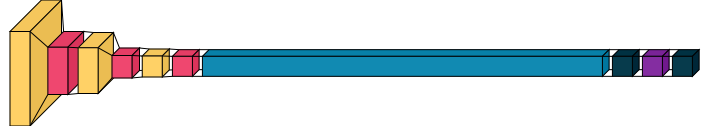

In [15]:
visualkeras.layered_view(model, scale_xy=0.75)

# **Training and Evaluation**


In [17]:
history = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=EPOCHS,
    callbacks=[callback]
    )

Epoch 1/50


I0000 00:00:1741191165.680445    4849 service.cc:146] XLA service 0x79fe60003970 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1741191165.680474    4849 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Ti, Compute Capability 8.6
2025-03-05 11:12:45.730169: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-03-05 11:12:45.841669: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 90101


21/72 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3148 - loss: 2.8547

I0000 00:00:1741191168.385400    4849 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


72/72 ━━━━━━━━━━━━━━━━━━━━ 8s 66ms/step - accuracy: 0.3792 - loss: 2.1010 - val_accuracy: 0.5469 - val_loss: 1.2146
Epoch 2/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5890 - loss: 1.1833 - val_accuracy: 0.6551 - val_loss: 1.0517
Epoch 3/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6682 - loss: 1.0635 - val_accuracy: 0.6990 - val_loss: 0.9407
Epoch 4/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6905 - loss: 0.9963 - val_accuracy: 0.7010 - val_loss: 0.9744
Epoch 5/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7472 - loss: 0.9128 - val_accuracy: 0.7439 - val_loss: 0.8665
Epoch 6/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7609 - loss: 0.8483 - val_accuracy: 0.7235 - val_loss: 0.9189
Epoch 7/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7790 - loss: 0.8352 - val_accuracy: 0.8051 - val_loss: 0.7877
Epoch 8/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7800 - loss: 0.8078 - val_accuracy: 0.8449 - val_loss: 0.7312
Ep

In [18]:
# Evaluate using the train data
train_loss, train_acc = model.evaluate(X_train, y_train)
print(f"train accuracy: {100*train_acc:.2f}%")

# Evaluate using the training data
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"test accuracy: {100*test_acc:.2f}%")

72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.9812 - loss: 0.4299
train accuracy: 98.03%
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.8765 - loss: 0.6504
test accuracy: 89.49%


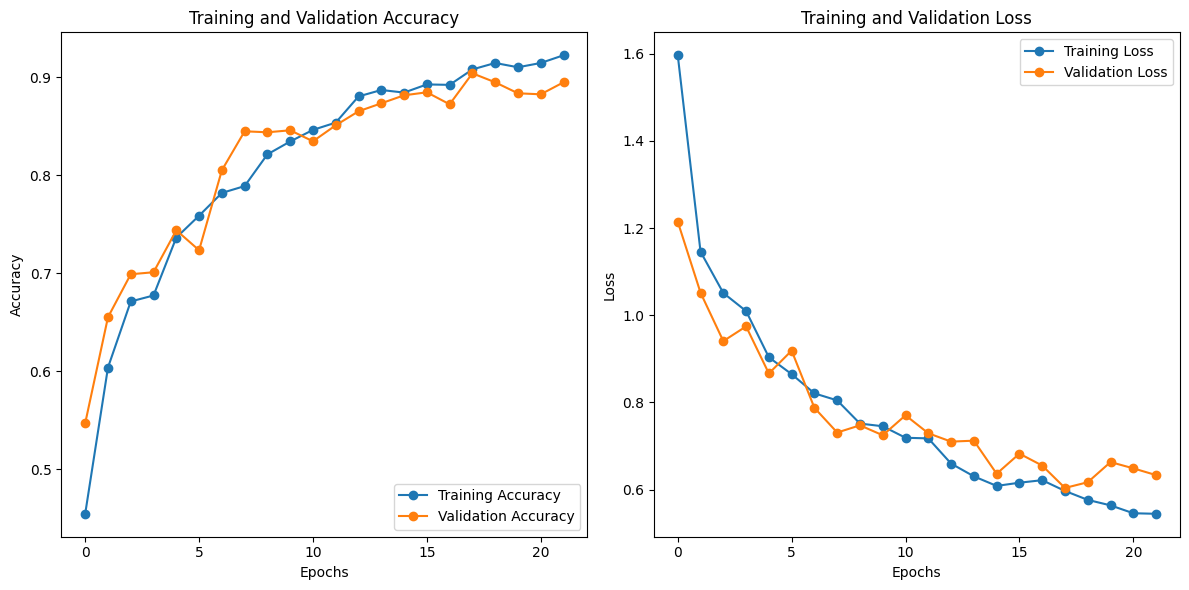

In [19]:
# Plot training and validation accuracy and loss
def plot_accuracy_loss(hist):
    train_acc = hist.history['accuracy']
    val_acc = hist.history['val_accuracy']
    train_loss = hist.history['loss']
    val_loss = hist.history['val_loss']

    # Update the range to match the number of epochs
    epochs_range = range(len(train_acc))  # Automatically adjusts to the number of epochs

    plt.figure(figsize=(12, 6))

    # Plot training and validation accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_acc, marker = 'o', label='Training Accuracy')
    plt.plot(epochs_range, val_acc, marker = 'o', label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')

    # Plot training and validation loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, train_loss, marker = 'o', label='Training Loss')
    plt.plot(epochs_range, val_loss, marker = 'o', label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')

    plt.tight_layout()
    plt.show()

plot_accuracy_loss(history)

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


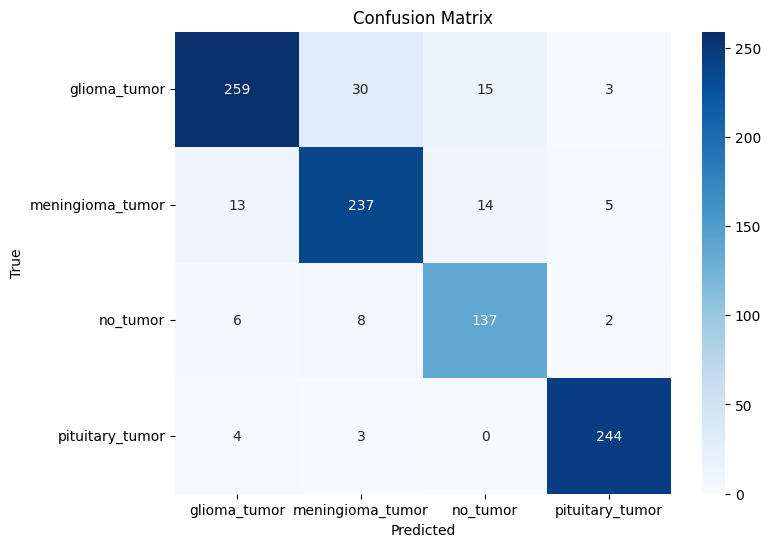

In [20]:
# Get predictions for test set
y_pred = model.predict(X_test)

# Convert predictions and true labels to class indices
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# Define class names
class_names = ["glioma_tumor", "meningioma_tumor", "no_tumor", "pituitary_tumor"]

# Create confusion matrix
conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)

# Plot confusion matrix as heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

## **Reflection**

The project successfully demonstrated the feasibility of using deep learning to detect and classify brain tumors from MRI data. Key achievements include:
- Effective Model Performance: The CNN model had an an accuracy of 97.46% on the training set, and 88.06% on the test set.
- Data Utilization: Usage of publicly available Kaggle datasets made for reliable training and evaluation
- Insight: The project's results confirm that automated analysis has real-world applications.

Moving forward, we plan to incorporate data augmentation, and better preprocessing steps to improve performance.